# Feature Importance Via Gradients

In order to determine the importance of features in classifying species based on DNA sequences, we consider the components of inputted DNA sequences that are critical in enabling the classifier to make its predictions. We do so using a method demonstrated in the following link: http://www.unofficialgoogledatascience.com/2017/03/attributing-deep-networks-prediction-to.html.  

In this method, feature importance is determined by calculating the gradients of the output (species prediction scores) with respect to our input (one-hot encoded DNA sequences). When we multiply the inputted one-hot encoded DNA sequence by the corresponding gradient, we are in effect using a first-order Taylor approximation of the maximum prediction score (the largest output of the Softmax function in the last layer, i.e. our predicted label). By performing this element-wise multiplication, we expect to "highlight" the portions of the inputted DNA sequence that contribute the most greatly to the predicted label. However, as is the case with classifying images in the example from the online link, a straightforward gradient calculation and subsequent Taylor series approximation is insufficient for accurately approximating the output. When determining the gradients associated with a randomly chosen DNA sequence, we see immediately that almost all of the gradient values to be multiplied to the input are very low (~10^-5). This phenomenon is due largely in part to the rapidity of saturation for the label-specific prediction score near the input. In other words, when scaling down the "intensities" of the inputs via a scaling parameter, we would observe that the prediction scores reach their maximum values at low values of the scaling parameter.  

In order to combat this obstacle, we can use integrated gradients, as is done in the online example. For the full implementation of the integrated gradients approach, see analysis.py.  

Below, we show an example of the workflow required to get feature attributions for a single example in the species classification task.  

In [ ]:
from analysis import * 

model_name = 'all8_model'
model_dir = ''
testdata_file = 'data/h5datasets/all8/validation.h5'

# restore graph
sess = tf.Session()
saver = tf.train.import_meta_graph(model_dir + model_name + '.meta')
saver.restore(sess,'./' + model_dir + model_name)

f = h5py.File(testdata_file,'r')
dnaseq = f['dnaseq'][6]
lab = f['species_labels'][6]

graph = tf.get_default_graph()

# identify relevant placeholders and operations
dna = graph.get_tensor_by_name("dna:0")
labels = graph.get_tensor_by_name("label:0")
dropout1 = graph.get_tensor_by_name("dropout_1/keras_learning_phase:0")
rep = graph.get_tensor_by_name('representation/Relu:0')
preds = graph.get_tensor_by_name('dense_1/Softmax:0')

feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}

grads_attrs = integrated_gradients(sess,graph,dnaseq)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

### Using Integrated Gradients to Highlight Transcription Factor Binding Motifs  

In order to validate the effectiveness of integrated gradients as a means of determining regions in DNA sequences that are important in predictions, we apply integrated gradients to a model predicting the presence (or absence) of TF binding motifs. As a simple way to generate data for this validation effort, we simulate DNA sequences using SimDNA from the Kundaje Lab. We generate sequences that contain known TF binding motifs (TAL1) and sequences that do not. We then train a neural network via supervised learning to differentiate between sequences with and without the TF binding motifs. Details about the data and the model architecture are as follows.  

- Data Generation: (see *Mutator Adversarial Networks* for commands used to simulate the DNA sequences)  
- DNA sequences: either one or no TAL1 motif in each 200bp sequence (with one-hot encoded labels); 50,000 sequences each for motif-containing set and no motif set   
- Model Architecture: [Conv/Drop] -> [Conv/Drop] -> [Conv/Pool/Drop] (trained for 30 epochs)  

Validation Categorical Accuracy: ~0.999 

**Future Ideas:**  
Importantly, we also consider inserting mutated versions of the TF binding motifs into the DNA sequences to see if a model can learn to identify "sufficiently similar" binding motifs. Another interesting question to answer is to see if the model can perform better when the underlying data consists of real DNA sequences (with the inserted real TF binding motifs) or when the underlying data uses randomly shuffled DNA sequences. 


In [1]:
execfile('analysis.py')

model_name = 'TAL1_background_simDNAmodel'
model_dir = 'results/TAL1_background/'

# restore graph
sess = tf.Session()
saver = tf.train.import_meta_graph(model_dir + model_name + '.meta')
saver.restore(sess,'./' + model_dir + model_name)

graph = tf.get_default_graph()

# identify relevant placeholders and operations
dna = graph.get_tensor_by_name("dna:0")
labels = graph.get_tensor_by_name("label:0")
dropout1 = graph.get_tensor_by_name("dropout_1/keras_learning_phase:0")
rep = graph.get_tensor_by_name('representation/Relu:0')
preds = graph.get_tensor_by_name('dense_1/Softmax:0')

Using TensorFlow backend.


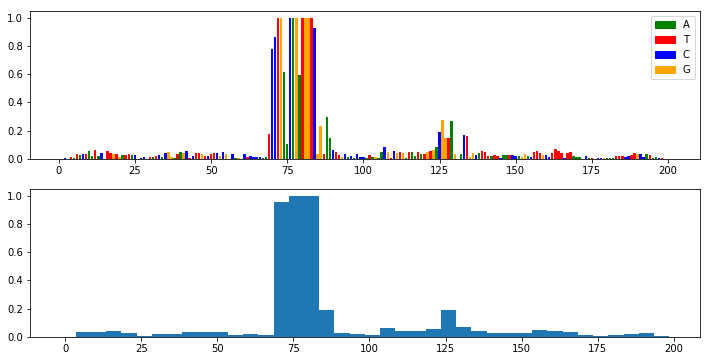

In [2]:
%matplotlib inline

from analysis import * 

testdata_file = 'data/simulated_dna/TAL1_background/validation.h5'
f = h5py.File(testdata_file,'r')

# get example with TAL1 motif (CTGAACAGATGGTCGG)
dnaseq = f['dnaseq'][4] 
lab = f['labels'][4]

feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}

grads_attrs = integrated_gradients(sess,graph,dnaseq)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

f.close()

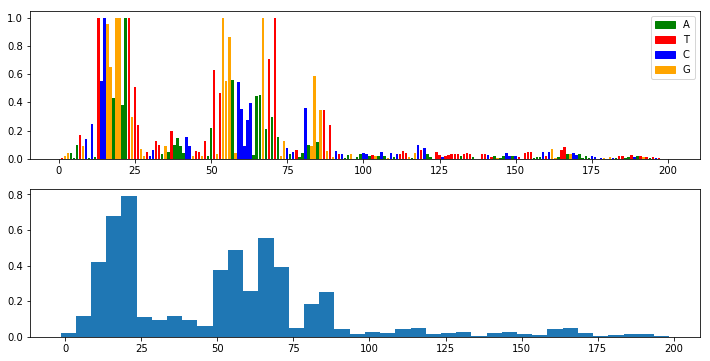

In [3]:
testdata_file = 'data/simulated_dna/TAL1_background/validation.h5'
f = h5py.File(testdata_file,'r')

# get example without embedded motif
dnaseq = f['dnaseq'][0] 
lab = f['labels'][0]

feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}

grads_attrs = integrated_gradients(sess,graph,dnaseq)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

f.close()

### Using Integrated Gradients to Highlight Important Parts of "Real" DNA

We have observed that convolutional neural networks are capable of effectively distinguishing between real DNA sequences and shuffled (or randomly generated) DNA sequences. This phenomenon suggests that there are some underlying features in real DNA sequences that are biologically or chemically important to its underlying structure or mechanism. What these features are is currently a mystery. We can try to use integrated gradients on a model trained to classify real and simulated DNA sequences. This initial task will tell us how different simulated sequences from SimDNA are from the sequences of promoter regions.   

- Data Generation: Human promoters (200bp upstream from coding region) vs. simulated background sequences w/o motifs (see *Mutator Adversarial Networks* for commands used to simulate the DNA sequences)   
- Model Architecture: [Conv/Drop] -> [Conv/Drop] -> [Conv/Pool/Drop] (trained for 30 epochs)   

Validation Categorical Accuracy: ~0.98  



We can also do the same for real DNA sequences and shuffled versions of the sequences.  

In [4]:
execfile('analysis.py')

model_name = 'Human_background_simDNAmodel'
model_dir = 'results/Human_background/'

# restore graph
sess = tf.Session()
saver = tf.train.import_meta_graph(model_dir + model_name + '.meta')
saver.restore(sess,'./' + model_dir + model_name)

graph = tf.get_default_graph()

# identify relevant placeholders and operations
dna = graph.get_tensor_by_name("dna:0")
labels = graph.get_tensor_by_name("label:0")
dropout1 = graph.get_tensor_by_name("dropout_1/keras_learning_phase:0")
rep = graph.get_tensor_by_name('representation/Relu:0')
preds = graph.get_tensor_by_name('dense_1/Softmax:0')

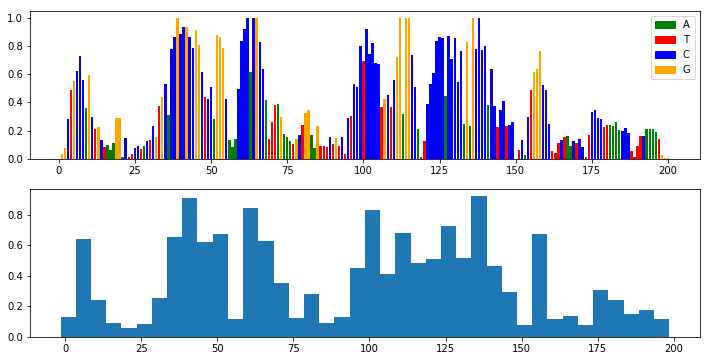

In [10]:
testdata_file = 'data/simulated_dna/Human_background/validation.h5'
f = h5py.File(testdata_file,'r')

# get example with Human promoter DNA
dnaseq = f['dnaseq'][8] 
lab = f['labels'][8]

feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}

grads_attrs = integrated_gradients(sess,graph,dnaseq)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

f.close()

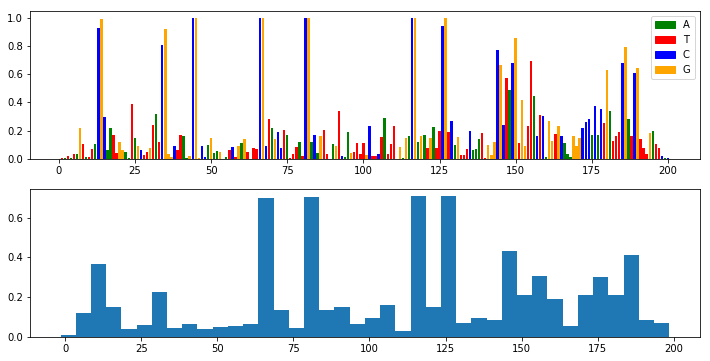

In [13]:
testdata_file = 'data/simulated_dna/Human_background/validation.h5'
f = h5py.File(testdata_file,'r')

# get example with simulated background DNA
dnaseq = f['dnaseq'][1] 
lab = f['labels'][1]

feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}

grads_attrs = integrated_gradients(sess,graph,dnaseq)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

f.close()

### Using Integrated Gradients to Highlight Important Regions Separating Promoters from Different Species 

Here, we simply want to see with our own eyes the features that appear important to the model for distinguishing between different species. In particular, we choose examples of promoters for which the model predicts with a high prediction score (i.e. probability) the correct species. We use the method of integrated gradients to highlight the features that are most important for classifying each example promoter to its assigned species label.  

**Architecture: [Conv/Drop] -> [Conv/Pool/Drop] -> [Conv/Pool/Drop]** (no regularization, w/ 80 filters of width 2)    
Epochs: 60  
Training Accuracy: ~0.78  
Validation Accuracy: ~0.54  

In [1]:
execfile('analysis.py')

model_name = 'all8_filter2model'
model_dir = 'results/all8_filter2/'

# restore graph
sess = tf.Session()
saver = tf.train.import_meta_graph(model_dir + model_name + '.meta')
saver.restore(sess,'./' + model_dir + model_name)

graph = tf.get_default_graph()

# identify relevant placeholders and operations
dna = graph.get_tensor_by_name("dna:0")
labels = graph.get_tensor_by_name("label:0")
dropout1 = graph.get_tensor_by_name("dropout_1/keras_learning_phase:0")
rep = graph.get_tensor_by_name('representation/Relu:0')
preds = graph.get_tensor_by_name('dense_1/Softmax:0')

Using TensorFlow backend.


In [17]:
'''HUMAN PROMOTER'''
# get example with Human promoter DNA
testdata_file = 'data/h5datasets/all8/validation.h5'
f = h5py.File(testdata_file,'r')
dnaseq = f['dnaseq'][67] # human
lab = f['species_labels'][67] # human
f.close()

# get prediction scores
predicted_labels = sess.run(preds,feed_dict={dna: [dnaseq],labels: [lab],dropout1: 0})
print(predicted_labels)

[[  3.55975459e-07   5.40494739e-06   2.69198686e-01   7.29571998e-01
    1.90812963e-10   1.21832464e-03   5.17184844e-06   9.60056852e-08]]


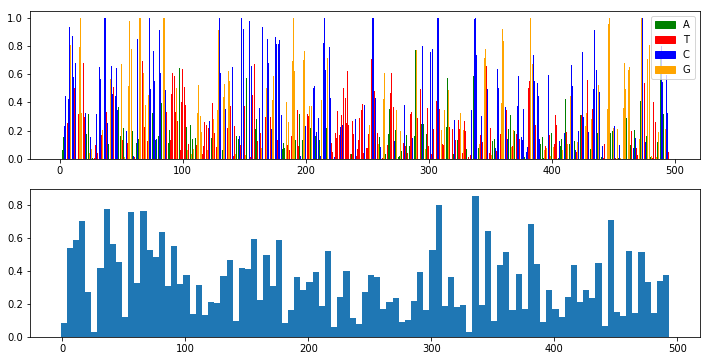

In [18]:
# apply integrated gradients and plot feature attributions
feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}
grads_attrs = integrated_gradients(sess,graph,dnaseq,labelIdx=3)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

In [14]:
'''MOUSE PROMOTER'''
# get example with Mouse promoter DNA
testdata_file = 'data/h5datasets/all8/validation.h5'
f = h5py.File(testdata_file,'r')
dnaseq = f['dnaseq'][14]
lab = f['species_labels'][14]
f.close()

# get prediction scores
predicted_labels = sess.run(preds,feed_dict={dna: [dnaseq],labels: [lab],dropout1: 0})
print(predicted_labels)

[[  6.65659318e-05   8.96883721e-05   7.64046729e-01   1.95355430e-01
    1.59800663e-06   4.03748453e-02   1.28968295e-05   5.22608098e-05]]


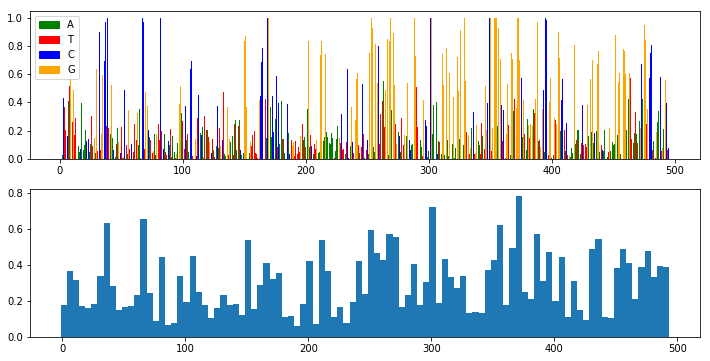

In [15]:
# apply integrated gradients and plot feature attributions
feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}
grads_attrs = integrated_gradients(sess,graph,dnaseq,labelIdx=2)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

In [22]:
'''ZEBRAFISH PROMOTER'''
# get example with Zebrafish promoter DNA
testdata_file = 'data/h5datasets/all8/validation.h5'
f = h5py.File(testdata_file,'r')
dnaseq = f['dnaseq'][33]
lab = f['species_labels'][33]
f.close()

# get prediction scores
predicted_labels = sess.run(preds,feed_dict={dna: [dnaseq],labels: [lab],dropout1: 0})
print(predicted_labels)

[[  2.25258656e-04   2.42631976e-03   5.07855555e-03   9.66884382e-03
    8.28832781e-05   9.58885312e-01   2.34949645e-02   1.37843032e-04]]


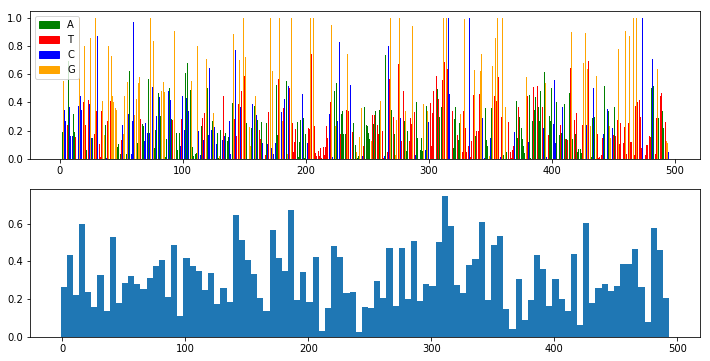

In [23]:
# apply integrated gradients and plot feature attributions
feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}
grads_attrs = integrated_gradients(sess,graph,dnaseq,labelIdx=5)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

In [24]:
'''DROSOPHILA PROMOTER'''
# get example with Zebrafish promoter DNA
testdata_file = 'data/h5datasets/all8/validation.h5'
f = h5py.File(testdata_file,'r')
dnaseq = f['dnaseq'][4]
lab = f['species_labels'][4]
f.close()

# get prediction scores
predicted_labels = sess.run(preds,feed_dict={dna: [dnaseq],labels: [lab],dropout1: 0})
print(predicted_labels)

[[  2.69881075e-05   1.61597133e-02   8.62054731e-06   5.30773723e-05
    2.34784762e-04   8.62407964e-03   9.74873841e-01   1.88639096e-05]]


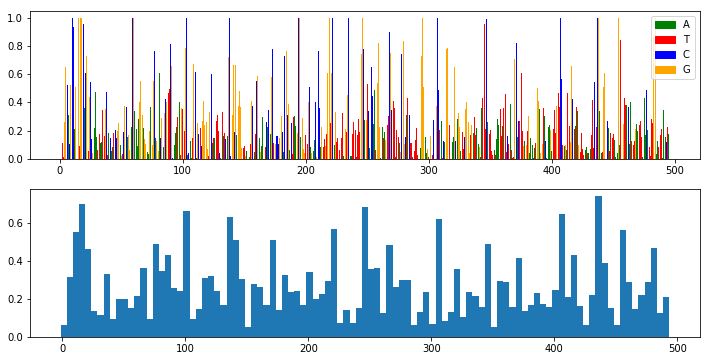

In [25]:
# apply integrated gradients and plot feature attributions
feed_dict = {dna: dnaseq, labels: lab, dropout1: 0}
grads_attrs = integrated_gradients(sess,graph,dnaseq,labelIdx=6)
scaled_dna = scaleAttr_dnaseq(dnaseq,grads_attrs,ptile=99)
plotAttr_dnaseq(scaled_dna)

# Densely Connected Convolutional Networks (Densenet)  

In an effort to improve the effectiveness of our convolutional neural network models, we seek to implement Densenet, a variation of the traditional convolutional neural network. One of the issues with CNNs that it seeks to tackle is the reduction of information (about the input or gradient) as it is passed from one convolutional layer to the next. For a sequential model with multiple convolutional layers, it is possible that a sizable portion of this information is lost. Information is only passed from one layer to the next, so previously gathered information from an earlier layer is only passed in the form of the output of a present layer. Densenet's key feature is the connection of all convolutional layers (with matching feature map sizes) directly with each other. This not only increases the information flow throughout the network, but it requires fewer parameters in the overall network, too, as there is no need for the network to relearn redundant feature maps. Due to these added benefits, we seek to develop a Densenet model to cater to our classification tasks.  

Notes on implementation details can be found here: https://medium.com/intuitionmachine/notes-on-the-implementation-densenet-in-tensorflow-beeda9dd1504.  

The full implementation of Densenet for species classification can be found in main_h5dense.py.  

**Regular Keras + Tensorflow Model (Baseline)**  
**Architecture: [Conv/Pool/Drop] -> [Conv/Pool/Drop] -> [Conv/Pool/Drop]**  
Epochs: 110 (80 original + 30 more epochs)    
End Training Accuracy: ~0.76 (~0.71 at 80 epochs)  
End Validation Accuracy: ~0.58 (~0.58 at 80 epochs)  

**Regular Keras + Tensorflow Model (Alternative w/ less pooling)**  
**Architecture: [Conv/Drop -> Conv/Drop -> Conv/Pool/Drop] -> [Conv/Drop -> Conv/Drop -> Conv/Pool/Drop]**  
Epochs: 60  
End Training Accuracy: ~0.70  
End Validation Accuracy: ~0.53 (potential room for improvement...loss function appears to still be declining)    

**Regular Keras + Tensorflow Model (Alternative w/ Batch Normalization)**  
**Architecture: [Conv/Batch/Drop] -> [Conv/Batch/Pool/Drop] -> [Conv/Batch/Pool/Drop]**  
Epochs: 40  
End Training Accuracy: ~0.10  
End Validation Accuracy: ~0.10 (horrible...)  


## Densenet
**Denseblock = [Conv/Leak/Drop] -> Concat -> [Conv/Leak/Drop] -> Concat -> [Conv/Leak/Drop]**  

**Architecture: Conv/Drop -> [Denseblock] -> [Conv/Pool/Drop] -> [Denseblock] -> [Conv/Pool/Drop]**  
Epochs: 30  
End Training Accuracy: ~0.30  
End Validation Accuracy: ~0.28 (training loss doesn't appear to be decreasing...strange?)  

**Architecture: [Conv/Pool/Drop] -> [Denseblock] -> [Conv/Pool/Drop]**  
Epochs: 30  
End Training Accuracy: ~0.85 
End Validation Accuracy: ~0.51 (validation accuracy appears to be increasing...signs of overfitting)  

**Architecture: [Conv/Batch/Pool/Drop] -> [Denseblock w/ Batch Normalization] -> [Conv/Batch/Pool/Drop]**  
Epochs: 40  
End Training Accuracy: ~0.87 (@ 40 epochs), ~0.78 (@ 20 epochs)     
End Validation Accuracy: ~0.50 (@ 40 epochs), ~0.53 (@ 20 epochs)  


# Recurrent Neural Networks

In addition to using convolutional layers in our neural networks, we seek to implement recurrent layers. Unlike convolutional layers, which capture local patterns across an inputted image/sequence, recurrent networks can more explicitly capture lateral patterns. This feature is particularly useful for understanding the semantics of DNA sequences holistically rather than in smaller subsequences.  

**Implementation Possibilities:**  
1) RNN across an entire promoter sequence (i.e. timestep of 500) - this takes way too much time to train (essentially entails training a network with 500 dense layers - one for each base pair position)  
2) Reduce the dimensionality of the promoter sequence using an initial convolutional/pooling layer  
3) Split each promoter sequence into smaller subsequences, use a recurrent layer to capture sequence features for each subsequence, combine the extracted sequence features associated with each original sequence, apply another recurrent layer to capture the sequence dependencies between the extracted features  


# Mutator Adversarial Networks

We're currently investigating the possibiltiy of developing a model for DNA mutational analysis that mirrors the architecture of generative adversarial networks. The primary goal is to use this model to determine what aspects of real DNA sequences make it easily distinguishable from randomly shuffled DNA sequences in simple neural network models. Instead of generating real DNA sequences from a vector of random elements (as is commonly done with image generation), we seek to generated mutated DNA sequences from real DNA sequences to "trick" the Discriminator. Thus, our input is a batch of real DNA sequences, which for some iterations of the algorithm is passed through a Mutator to generate mutant sequences that are designed specifically to "trick" the Discriminator. In other words, the job of the Mutator is to "intelligently mutate" the real DNA sequences such that they still retain the apparent structure real DNA sequences. In doing so, we can determine what types of substructures in the DNA are "important" and need to be consistently added (or retained) via the Mutator's adjustment process. For other iterations in the algorithm, the batch of real DNA sequences is passed through the Discriminator to train it to differentiate between the generated mutants and the real DNA sequences.  

We first generate simulated DNA sequences with known motifs using the SimDNA software from the Kundaje Lab (https://github.com/kundajelab/simdna).  

In the original version of the Mutator Adversarial Network, we define the Mutator loss function to be the average negative log of the probability that each mutated sequence in the batch is a real sequence. One way to improve the mutator component of the network is to change this loss function. Instead of trying to simply "trick" the Discriminator as the main objective, our main objective can be to match the representations of mutant sequences and real sequences. We do this by feeding the mutated sequences and real sequences into a hidden layer (or many) after the mutant sequences are generated and retaining the output of this hidden layer as a representation layer. In our initial attempt at this approach, we simply apply a 2D convolutional layer, flatten the output, and apply a fully connected layer to output a vector of size 50 to serve as our representation layer. We then use the Kullback-Leibler divergence to evaluate the difference between the representations of the mutant sequences and real sequences.  

## Priming the Discriminator  

Thus far, we've observed that the Discriminator does a very poor job at discriminating between real and mutated DNA sequences. A possible reason behind this occurrence is that, even when allowing the Discriminator to be trained many times before the mutator has the opportunity to "react", the Discriminator just simply is not trained sufficiently long enough to accurately classify real or mutated sequences.  

In order to account for this problem, we can initialize the Discriminator to be a network that is designed specifically at first to distinguish between randomly generated DNA sequences and real promoter sequences. We would have to first train this component of the network to perform this particular task. Once training for this classification task is completed, we can train the Mutator to "trick" this trained Discriminator. Doing this should at the very least enable the Discriminator to have a good starting point for differentiating between the mutated sequences created by the Mutator and the real DNA sequences fed into the model. We attempt this method by choosing to generate sequences with the TAL1 binding motif from randomly generated "background" sequences.  

### New Model
Importantly, we also adjust our model to make it more amenable to our revised goals. Previously, we were using only real DNA sequences as input and feeding this input through both the Mutator and the Discriminator. As an update to our approach, we train the Discriminator using a separate labeled dataset - the dataset that we used previously to explicitly classify Human DNA sequences and background DNA sequences (or sequences with the TAL1 motif and sequences without it). Our input to the Mutator is an alternative set of randomly generated DNA sequences. Thus, our Discriminator is essentially being trained to perform the same exact task as our previous classification problem, while the Mutator's goal is to try to adjust the inputted randomly generated DNA sequences to create sequences with our desired features (i.e. TAL1 binding motif or real DNA sequence structures).  

## Efforts to "Mutate" in the TAL1 Binding Motif
**UPDATE:** We've attempted this approach by full training the Discriminator before training the Mutator. Results so far do not seem promising. The Mutator appears to be fully incapable of "tricking" the Discriminator even when hundreds of epochs/iterations are used for training the Mutator. Several key features may explain this result. Firstly, the Discriminator is most likely trained "too well" for the purposes of this approach. In order for the Discriminator to output a positive result (i.e. indicating the presence of the TAL1 motif), the motif *must* be present. This particular task causes problems with the loss function used to ultimately adjust weights in the Mutator component of the network. The randomly generated DNA sequences have no chance of producing a positive result except for on the very off chance that the Mutator happens to include a 10bp sequence that looks *exactly* like the desired motif. The probability of this occurring is incredibly small. In addition, the loss function is designed to be the average of the losses for all generated sequences from an inputted batch, so even in the off chance that we generate a sequence with the TAL1 motif, averaging will largely diminish the impact of the single positive output.  

We return to the old approach of alternating between training the Mutator and training the Discriminator. Because we know that training the Discriminator to distinguish between random sequences and sequences with the TAL1 motif requires just a few training examples, we need to ensure that the Mutator is trained much more frequently than the Discriminator.  
**NOTE:** This allocation of training between the Discriminator and the Mutator is usually the opposite of what is done with the typical Generative Adversarial Network. With GANs, the Discriminator is usually trained with multiple batches for each batch that is used to train the Generator.  

**UPDATE:** The goal of "intelligently" mutating random sequences to include a motif appears to be too difficult of a task given our current approach. Because of the very distinct sequence pattern in the desired motif, the Discriminator does a phenomenal job of identifying this feature rapidly and the Mutator is incapable of catching up to the Discriminator even when training the Mutator 3000x more frequently than the Discriminator. Our results show that the Mutator is able to "trick" the Discriminator when the Discriminator's training/validation accuracy is around 0.55, but once the Discriminator achieves around 0.70 accuracy values, the Mutator's "accuracy" of tricking the Discriminator drops precipitously to 0. Therefore, we decide to abandon our efforts to mutate in the TAL1 binding motif for now.  

## Efforts to Generate Real DNA Sequences
A simple task would appear to be generating real DNA sequences from background (i.e. randomly generated) DNA sequences. As we've seen in other work that we've done, the main difference between real DNA sequences and randomly generated DNA sequences is that real sequences tend to possess considerably more nucleotide repeats and considerably fewer CpG islands. Thus, our hope is that we can use the same approach as above to "mutate" in these nucleotide repeats and/or "mutate" out CpG islands. 

**Results:** Train Mutator for 30 epochs, 40x more frequently than Discriminator, 1 convolutional layer for Discriminator and Mutator  



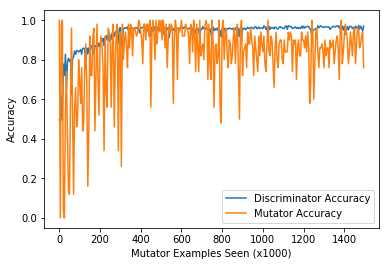

In [1]:
%matplotlib inline 

execfile('plots.py')

plotDiscMutAcc('MAN_Human_background.output')

## Ensuring Minimal Changes

While the goal of our Mutator network is to maximize the probability of "tricking" the Discriminator or mutating the inputted random sequence into a desired form, our current use of categorical entropy or negative log probability in the loss function causes the Mutator to essentially do whatever is necessary to create a positive label in the Discriminator. As a result, the Mutator will almost certainly take our inputted random sequence and rewrite the entire sequence, hopefully with the desired motif present (if the Mutator is effective). The Mutator will not simply just replace a portion of the inputted random sequence with the desired motif.  

Our hope eventually is to adjust the loss function such that not only can we generate a mutated sequence that contains the motif but we will also be able to retain much of the content of the original sequence. We can potentially accomplish this using the technique called "style transfer". The idea of style transfer comes from the practice of generating images that resemble an inputted image but possess the "style" of an alternative image. This task is performed by featuring a loss function that minimizes the difference in the "content" features between the inputted image and the generated image and the difference in the "style" features between the style template image and the generated image. The content "features" are simply defined as the outputs of convolutional layers in a model trained for image classification (i.e. VGG), while the "style" features are defined by a Gram matrix, which represents the correlation between features. 

## Additional Considerations

**Model Complexity:** Because the primary goal of our MAN is to "trick" the Discriminator and to do so rapidly enough to adjust to any updates in the Discriminator, it is important that we make the Mutator component of the network sufficiently simple. We want the Mutator to be rapidly updated to keep up with the Discriminator, so fewer parameters in the Mutator help us to achieve this purpose. Preliminary results appear to indicate that reducing the number of hidden layers in the Mutator enables the Mutator to more effectively "trick" the Discriminator.  

In [9]:
execfile('analysis.py')

model_name = 'TAL1_background_Mutmodel'
model_dir = ''

# restore graph
sess = tf.Session()
saver = tf.train.import_meta_graph(model_dir + model_name + '.meta')
saver.restore(sess,'./' + model_dir + model_name)

graph = tf.get_default_graph()

# identify relevant placeholders and operations
dna = graph.get_tensor_by_name("dna_input:0")
labels = graph.get_tensor_by_name("label:0")
dropout1 = graph.get_tensor_by_name("mutator/dropout_1/keras_learning_phase:0")
# rep = graph.get_tensor_by_name('representation/Relu:0')
mut_preds = graph.get_tensor_by_name('discriminator/prediction_mutant:0')
real_preds = graph.get_tensor_by_name('discriminator/prediction_nonmutant:0')

In [13]:
'''HUMAN PROMOTER'''

mutant = graph.get_tensor_by_name('mutator/mutant:0')
preds = graph.get_tensor_by_name('discriminator/prediction/Softmax:0')

# get example with the TAL1 motif
testdata_file = 'data/simulated_dna/TAL1_background/validation.h5'
f = h5py.File(testdata_file,'r')
dnaseq = f['dnaseq'][0:5]
lab = f['labels'][0:5]
f.close()

print(lab)

# get prediction scores
predicted_labels_mutant = sess.run(preds,feed_dict={dna: dnaseq,dropout1: 0})
print(predicted_labels_mutant)

# predicted_labels_mutant = sess.run(real_preds,feed_dict={dna: dnaseq,dropout1: 0})
# print(predicted_labels_mutant)

[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
[[ 0.00327699  0.996723  ]
 [ 0.00474428  0.99525565]
 [ 0.00415285  0.99584717]
 [ 0.00397302  0.99602699]
 [ 0.00426848  0.99573153]]


In [3]:
lab

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [10]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

[u'dna_input',
 u'label',
 u'temperature',
 u'mutator/conv_1/random_uniform/shape',
 u'mutator/conv_1/random_uniform/min',
 u'mutator/conv_1/random_uniform/max',
 u'mutator/conv_1/random_uniform/RandomUniform',
 u'mutator/conv_1/random_uniform/sub',
 u'mutator/conv_1/random_uniform/mul',
 u'mutator/conv_1/random_uniform',
 u'mutator/conv_1/kernel',
 u'mutator/conv_1/kernel/Assign',
 u'mutator/conv_1/kernel/read',
 u'mutator/conv_1/Const',
 u'mutator/conv_1/bias',
 u'mutator/conv_1/bias/Assign',
 u'mutator/conv_1/bias/read',
 u'mutator/conv_1/convolution/Shape',
 u'mutator/conv_1/convolution/dilation_rate',
 u'mutator/conv_1/convolution',
 u'mutator/conv_1/BiasAdd',
 u'mutator/leaky_re_lu_1/Neg',
 u'mutator/leaky_re_lu_1/Relu',
 u'mutator/leaky_re_lu_1/Relu_1',
 u'mutator/leaky_re_lu_1/Const',
 u'mutator/leaky_re_lu_1/mul',
 u'mutator/leaky_re_lu_1/sub',
 u'mutator/AvgPool_1/AvgPool',
 u'mutator/dropout_1/keras_learning_phase',
 u'mutator/dropout_1/cond/Switch',
 u'mutator/dropout_1/con